In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tf_explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import glob
from tqdm import tqdm
import numpy as np
#np.random.seed = 42
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.utils import plot_model
from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
root_dir = '/content/drive/MyDrive/input/Dataset_BUSI_with_GT'
os.listdir(root_dir)

['.DS_Store', 'malignant', 'normal', 'benign']

In [ ]:
IMG_WIDTH = 128
IMG_HIGH = 128
IMG_CHANNELS = 3 # number of input channels

#EPOCHS = 200

In [ ]:
def LoadData(root_dir, FolderName, img_width=IMG_WIDTH, img_high=IMG_HIGH, img_channels=IMG_CHANNELS):
  num_samples = 0
  for address in glob.glob(root_dir + f'/{FolderName}/*'):
    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')
    if len(s_address) == 1:
      num_samples += 1

  X = np.zeros((num_samples, img_high, img_width, img_channels), dtype=np.uint8)
  Y = np.zeros((num_samples, img_high, img_width, 1), dtype=np.uint8)


  for address in tqdm(glob.glob(root_dir + f'/{FolderName}/*')):
    img = cv2.imread(address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (img_width, img_high), interpolation=cv2.INTER_CUBIC)

    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')

    idx = s_address[0]
    idx = int(idx.split('(')[1].split(')')[0]) - 1

    if len(s_address) == 1:
      X[idx] = resized_image
      
    elif len(s_address) > 1:
      mask = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
      
      mask = np.expand_dims(mask, axis=-1)
      Y[idx] = np.maximum(mask, Y[idx])

  return X, Y

In [ ]:
x_benign, y_benign = LoadData(root_dir, 'benign')
x_malignant, y_malignant = LoadData(root_dir, 'malignant')
x_normal, y_normal = LoadData(root_dir, 'normal')

100%|██████████| 266/266 [00:08<00:00, 31.60it/s]


In [ ]:
print(x_benign.shape, y_benign.shape, type(x_benign), type(x_benign))
print(x_malignant.shape, y_malignant.shape, type(x_malignant), type(y_malignant))
print(x_normal.shape, y_normal.shape, type(x_normal), type(y_normal))

(437, 128, 128, 3) (437, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(215, 128, 128, 3) (215, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(133, 128, 128, 3) (133, 128, 128, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
X = np.concatenate((x_benign, x_malignant, x_normal), axis=0)
y = np.concatenate((y_benign, y_malignant, y_normal), axis=0)

In [ ]:
X.shape, y.shape

((785, 128, 128, 3), (785, 128, 128, 1))

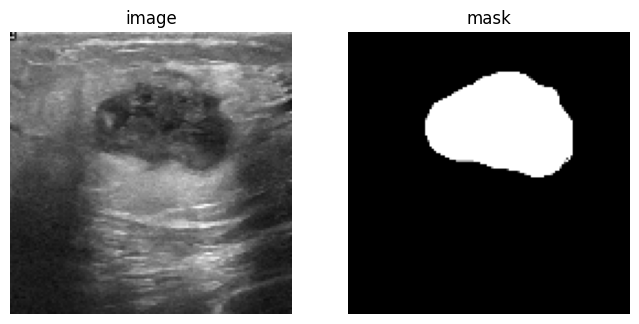

In [ ]:
## displaying data loaded by our function
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(X[529], cmap='gray')
plt.title('image')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(y[529]), cmap='gray')
plt.title('mask')
plt.axis('off');

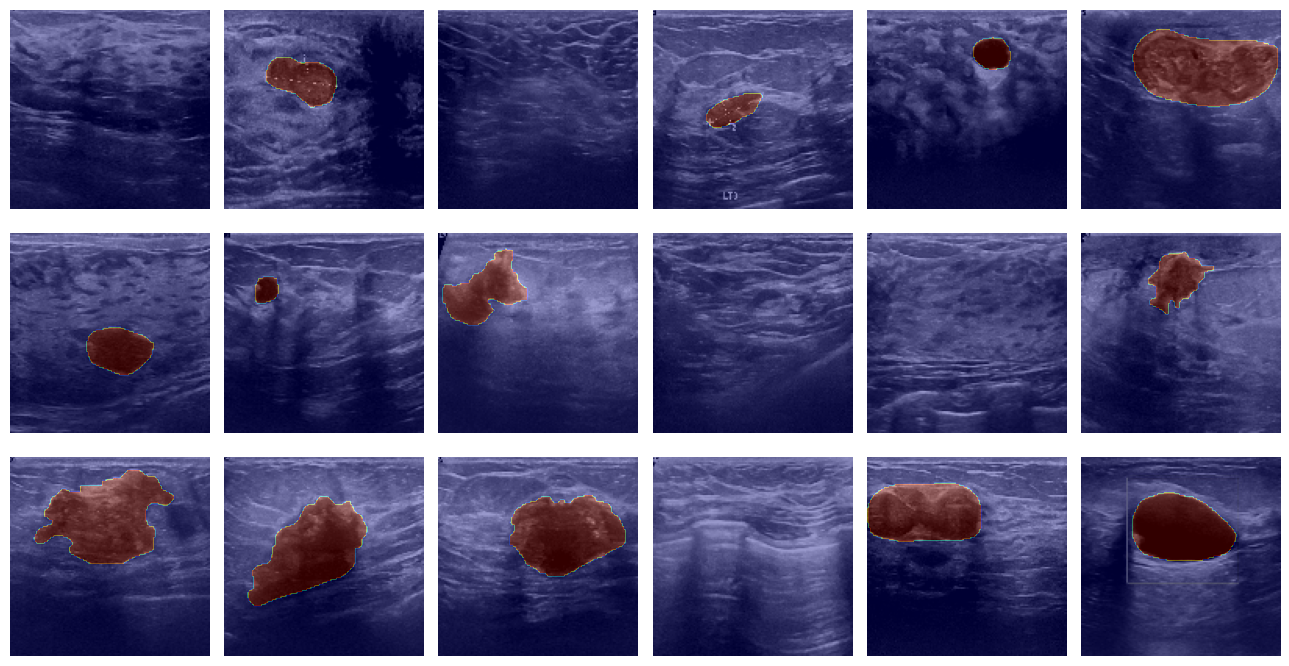

In [ ]:
#origonal plot
plt.figure(figsize=(13,7))
for i in range(18):
    plt.subplot(3,6,i+1)
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])
    plt.imshow(tf.squeeze(y[idx]), cmap='jet', alpha=0.4)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
X_norm = X / 255
y_norm = y / 255

In [ ]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_norm,
                                 y_norm, 
                                 test_size=0.1,
                                 random_state=11,
                                 #stratify=y_norm
                                 )
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                            y_train_val,
                            test_size=0.1,
                            random_state=11,
                            #stratify=y_train_val
                            )

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape





((635, 128, 128, 3),
 (635, 128, 128, 1),
 (71, 128, 128, 3),
 (71, 128, 128, 1),
 (79, 128, 128, 3),
 (79, 128, 128, 1))

In [ ]:
# RGB transform Gray
X_train = tf.image.rgb_to_grayscale(X_train)
X_test = tf.image.rgb_to_grayscale(X_test)
X_val = tf.image.rgb_to_grayscale(X_val)
type(X_train)
#Out[85]: tensorflow.python.framework.ops.EagerTensor
print(X_train.shape, X_test.shape, X_val.shape)
#(439, 224, 224, 1) (236, 224, 224, 1) (110, 224, 224, 1)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
type(X_train)
#Out[87]: numpy.ndarray

(635, 128, 128, 1) (79, 128, 128, 1) (71, 128, 128, 1)


numpy.ndarray

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, Concatenate, MaxPooling2D, BatchNormalization, Activation

In [ ]:
inply = Input((128, 128, 1))

conv1 = Conv2D(2**6, (3, 3), activation='relu', padding='same')(inply)
conv1 = Conv2D(2**6, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2), strides=2, padding='same')(conv1)
drop1 = Dropout(0.5)(pool1)

conv2 = Conv2D(2**7, (3, 3), activation='relu', padding='same')(drop1)
conv2 = Conv2D(2**7, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2), strides=2, padding='same')(conv2)
drop2 = Dropout(0.5)(pool2)

conv3 = Conv2D(2**8, (3, 3), activation='relu', padding='same')(drop2)
conv3 = Conv2D(2**8, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2), strides=2, padding='same')(conv3)
drop3 = Dropout(0.5)(pool3)

conv4 = Conv2D(2**9, (3, 3), activation='relu', padding='same')(drop3)
conv4 = Conv2D(2**9, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D((2, 2), strides=2, padding='same')(conv4)
drop4 = Dropout(0.5)(pool4)

convm = Conv2D(2**10, (3, 3), activation='relu', padding='same')(drop4)
convm = Conv2D(2**10, (3, 3), activation='relu', padding='same')(convm)

tran5 = Conv2DTranspose(2**9, (2, 2), strides=2,
                        padding='valid', activation='relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3, 3), activation='relu', padding='same')(conc5)
conv5 = Conv2D(2**9, (3, 3), activation='relu', padding='same')(conv5)
drop5 = Dropout(0.5)(conv5)

tran6 = Conv2DTranspose(2**8, (2, 2), strides=2,
                        padding='valid', activation='relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3, 3), activation='relu', padding='same')(conc6)
conv6 = Conv2D(2**8, (3, 3), activation='relu', padding='same')(conv6)
drop6 = Dropout(0.5)(conv6)

tran7 = Conv2DTranspose(2**7, (2, 2), strides=2,
                        padding='valid', activation='relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3, 3), activation='relu', padding='same')(conc7)
conv7 = Conv2D(2**7, (3, 3), activation='relu', padding='same')(conv7)
drop7 = Dropout(0.5)(conv7)

tran8 = Conv2DTranspose(2**6, (2, 2), strides=2,
                        padding='valid', activation='relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3, 3), activation='relu', padding='same')(conc8)
conv8 = Conv2D(2**6, (3, 3), activation='relu', padding='same')(conv8)

conv8 = BatchNormalization(axis=3)(conv8)
conv8 = Activation('relu')(conv8)
drop8 = Dropout(0.5)(conv8)

outly = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(drop8)
model = Model(inputs=inply, outputs=outly, name='U-net')

model.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
def dice_coef(y_test, y_pred):
  smooth = 1
  y_test_f = K.flatten(y_test)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_test_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_test_f * y_test_f) + K.sum(y_pred_f * y_pred_f) + smooth)



In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0003), loss='binary_crossentropy', metrics=[dice_coef])

In [ ]:
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=50)

Epoch 1/50
40/40 [==============================] - 43s 493ms/step - loss: 0.3989 - dice_coef: 0.2543 - val_loss: 0.3861 - val_dice_coef: 0.2718
Epoch 2/50
40/40 [==============================] - 10s 244ms/step - loss: 0.2431 - dice_coef: 0.3585 - val_loss: 0.2887 - val_dice_coef: 0.2233
Epoch 3/50
40/40 [==============================] - 10s 245ms/step - loss: 0.2209 - dice_coef: 0.3895 - val_loss: 0.2363 - val_dice_coef: 0.3428
Epoch 4/50
40/40 [==============================] - 10s 247ms/step - loss: 0.2092 - dice_coef: 0.4109 - val_loss: 0.2731 - val_dice_coef: 0.1310
Epoch 5/50
40/40 [==============================] - 10s 255ms/step - loss: 0.2015 - dice_coef: 0.4285 - val_loss: 0.2087 - val_dice_coef: 0.3612
Epoch 6/50
40/40 [==============================] - 10s 262ms/step - loss: 0.1952 - dice_coef: 0.4364 - val_loss: 0.1986 - val_dice_coef: 0.3656
Epoch 7/50
40/40 [==============================] - 10s 254ms/step - loss: 0.1806 - dice_coef: 0.4799 - val_loss: 0.2031 - val_dic

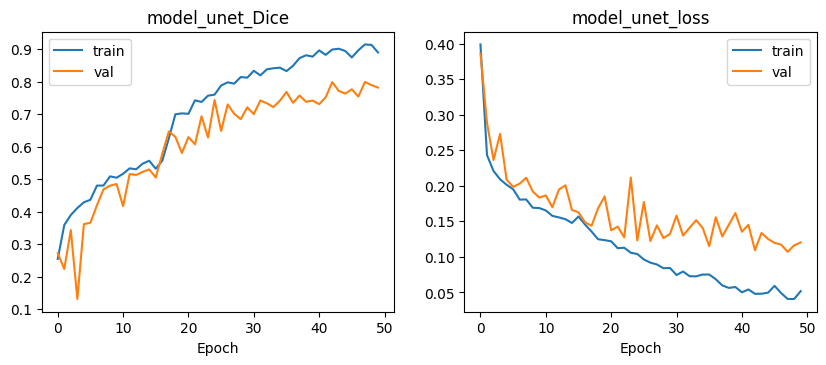

In [ ]:
#model_unet
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('model_unet_Dice')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model_unet_loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test dice', score[1])

3/3 [==============================] - 0s 103ms/step - loss: 0.1544 - dice_coef: 0.8015
Test loss:  0.15436239540576935
Test dice 0.8014940619468689


3/3 [==============================] - 0s 143ms/step


Text(0.5, 1.0, 'image')

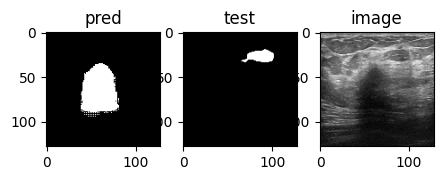

In [ ]:
pred = model.predict(X_test)
pred[pred>=0.5]=1
pred[pred<=0.5]=0

i=8
plt.figure(figsize=(5, 8))
plt.subplot(1, 3, 1)
plt.imshow(pred[i], cmap='gray')
plt.title("pred")
plt.subplot(1, 3, 2)
plt.imshow(y_test[i], cmap='gray')
plt.title("test")
plt.subplot(1, 3, 3)
plt.imshow(X_test[i], cmap='gray')
plt.title("image")



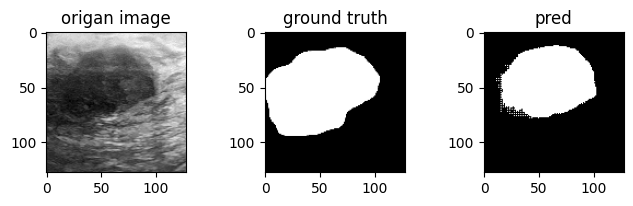

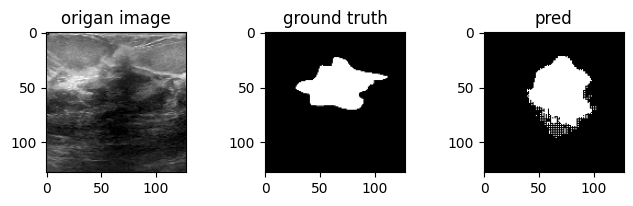

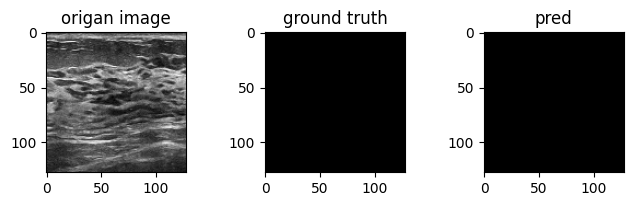

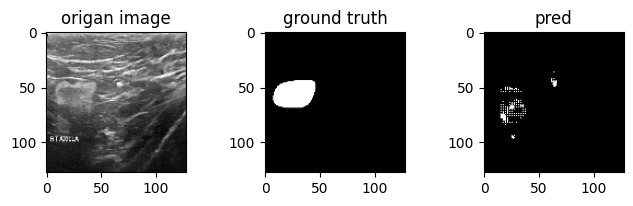

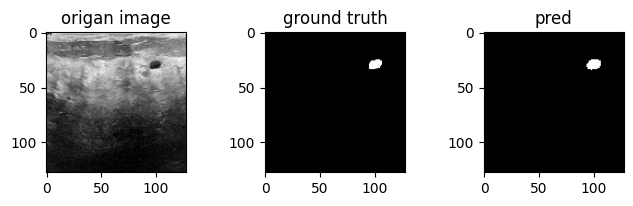

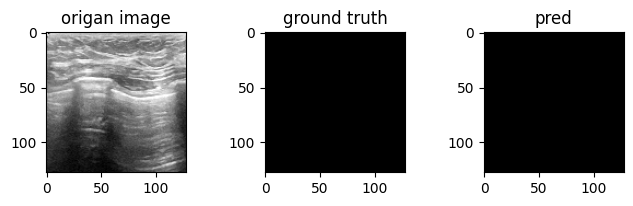

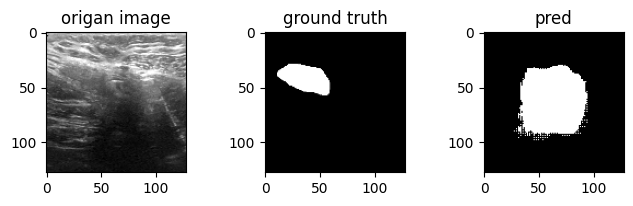

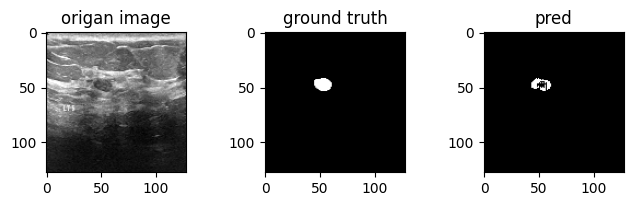

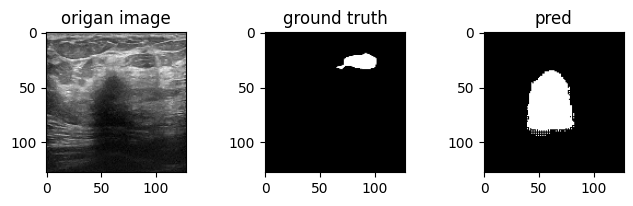

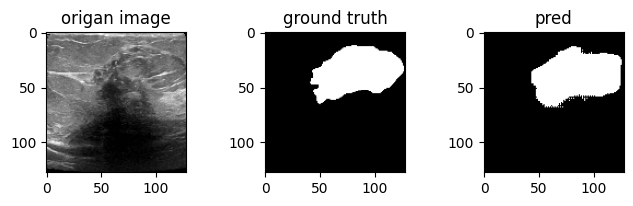

In [ ]:
for i in range(10):
  plt.figure(figsize=(8, 4))
  plt.subplot(2, 3, 1)
  plt.title("origan image")
  plt.imshow(X_test[i], cmap='gray')
  plt.subplot(2, 3, 2)
  plt.title("ground truth")
  plt.imshow(y_test[i], cmap='gray')
  plt.subplot(2, 3, 3)
  plt.title("pred")
  plt.imshow(pred[i], cmap='gray')
  plt.show()